In [1]:
import torch.nn as nn
import torch
from learned_dict import TiedSAE
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from transformers import ViTForImageClassification, ViTImageProcessor
from util import ActivationDataset, plot_activation
import torchvision.transforms as transforms
import seaborn as sns
import numpy as np
from collections import Counter


/ceph/kikang/miniconda3/envs/interp/lib/python3.11/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2024-03-06 16:35:39.892222: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 16:35:39.892282: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 16:35:39.894139: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-06 16:35:41.266408: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit_model = 'google/vit-base-patch16-224'
model = ViTForImageClassification.from_pretrained(vit_model, output_hidden_states=True).to(device)
model.eval()
processor = ViTImageProcessor.from_pretrained(vit_model)
to_pil = transforms.ToPILImage()

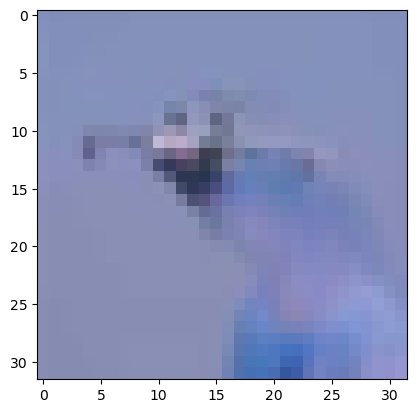

In [3]:
# Create a DataLoader
dataset = ActivationDataset('activations_cifar10_vit_b/cifar10_activations_0.h5','vit.encoder.layer.0.output')

data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
input_image = next(iter(data_loader))[0][0]
plt.imshow(input_image.permute(1,2,0))
input1 = processor(images=to_pil(input_image), return_tensors="pt").to(device)

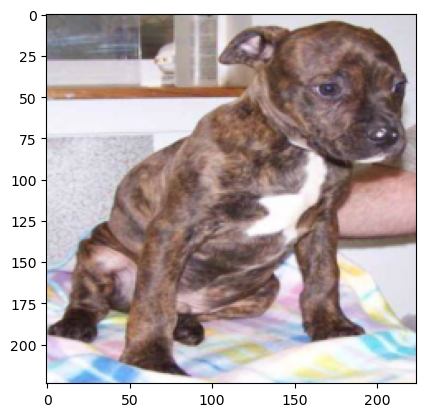

In [4]:
# Create a DataLoader
dataset = ActivationDataset('activations_catdog_vit_b/catdog_activations_1.h5','vit.encoder.layer.0.output')

data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
input_image2 = next(iter(data_loader))[0][0]
plt.imshow(input_image2.permute(1,2,0))
input2 = processor(images=to_pil(input_image), return_tensors="pt").to(device)

# Look into individual features activated with x10 model

layer 0


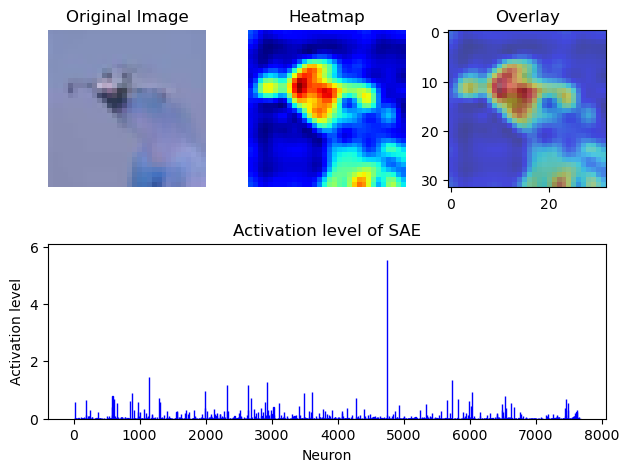

layer 1


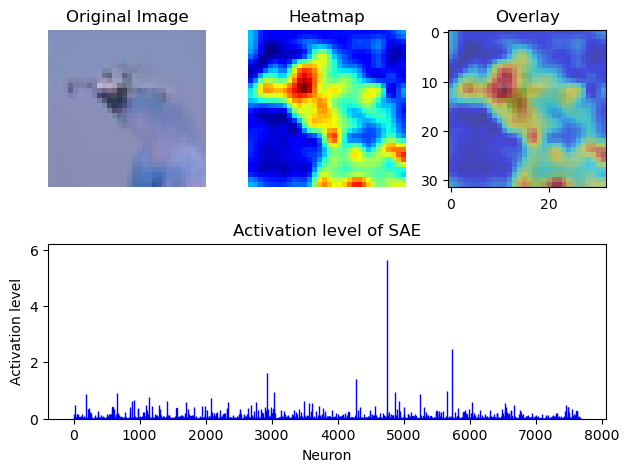

layer 2


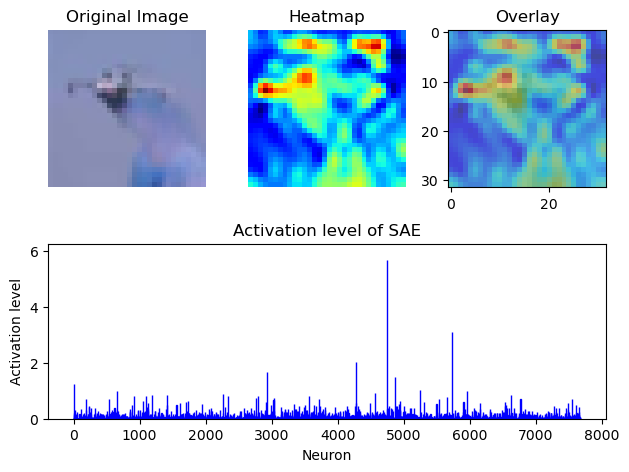

layer 3


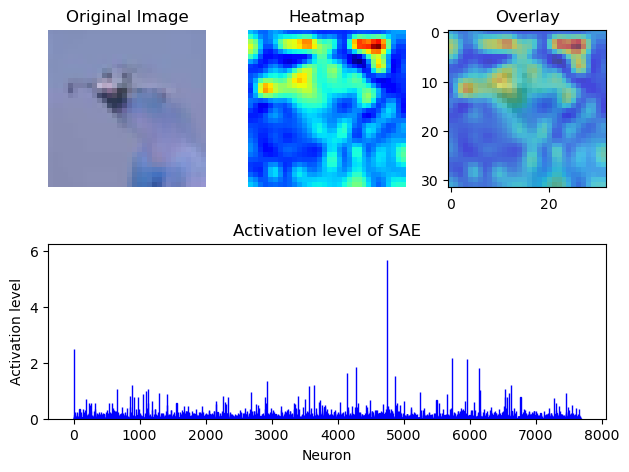

layer 4


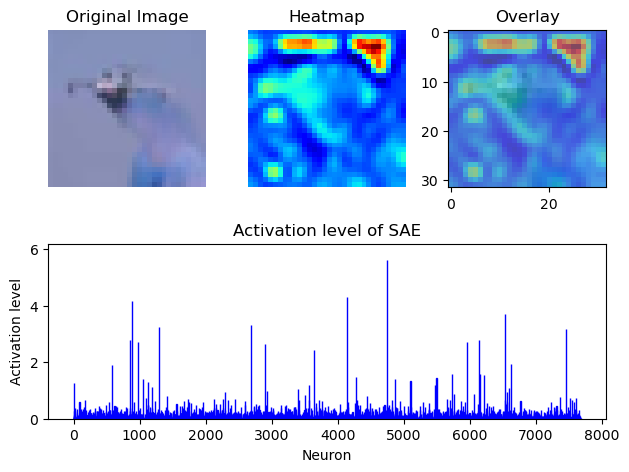

layer 5


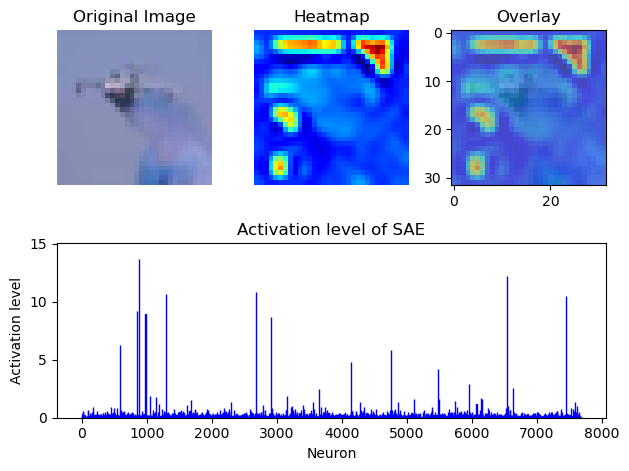

layer 6


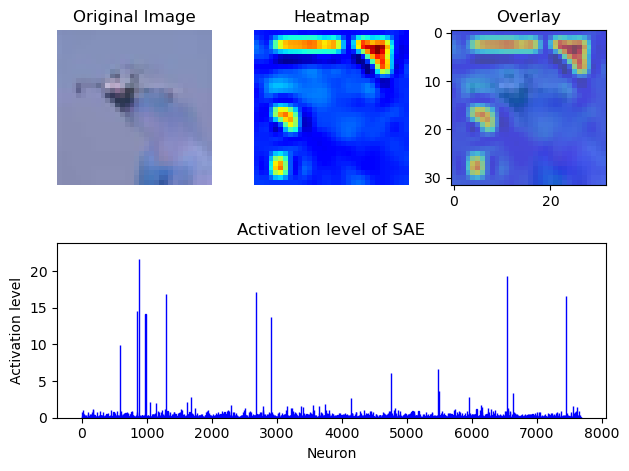

layer 7


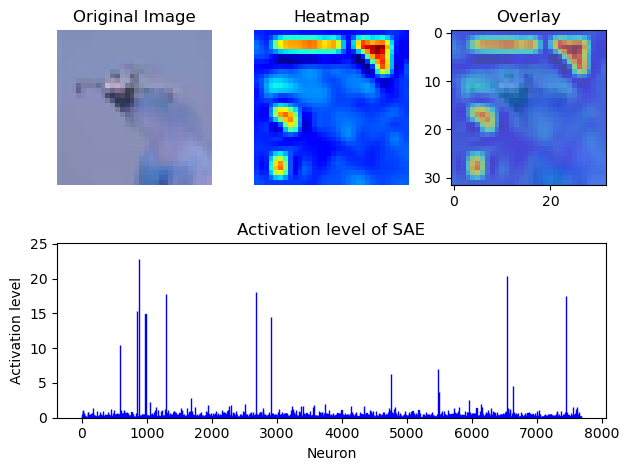

layer 8


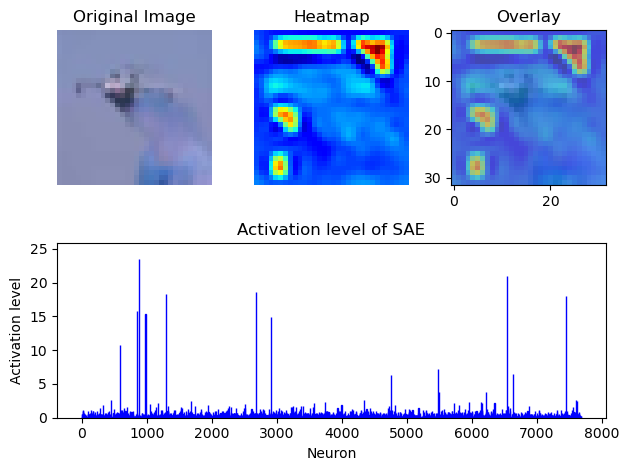

layer 9


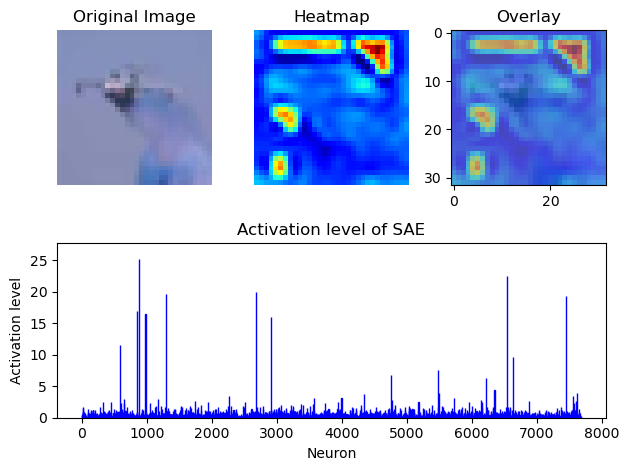

layer 10


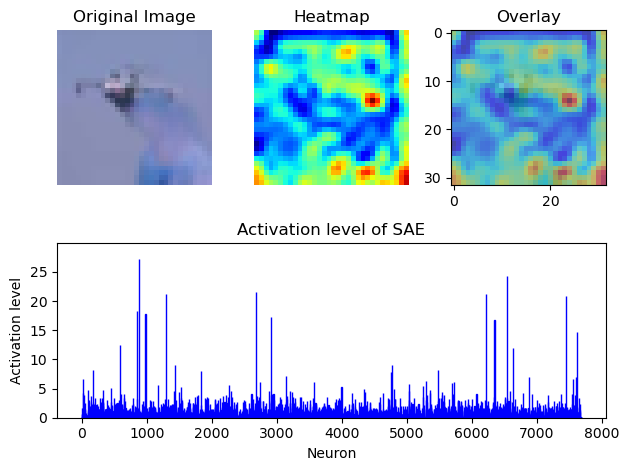

layer 11


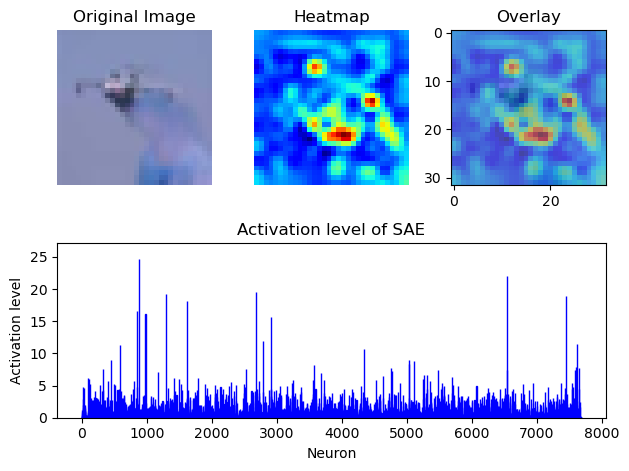

layer 0


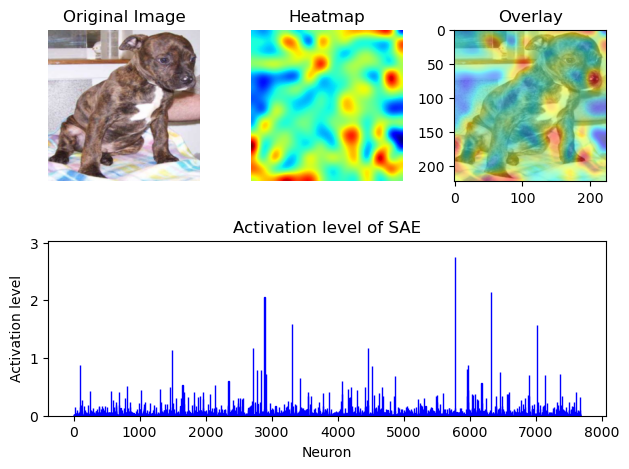

layer 1


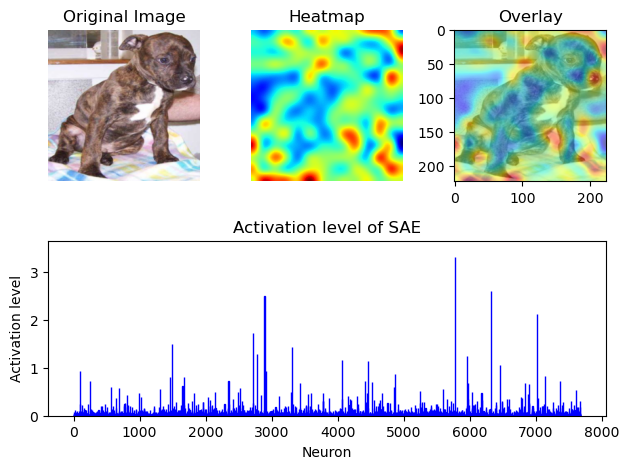

layer 2


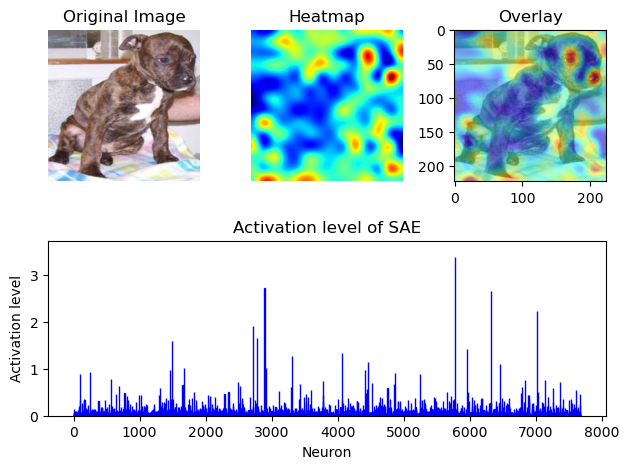

layer 3


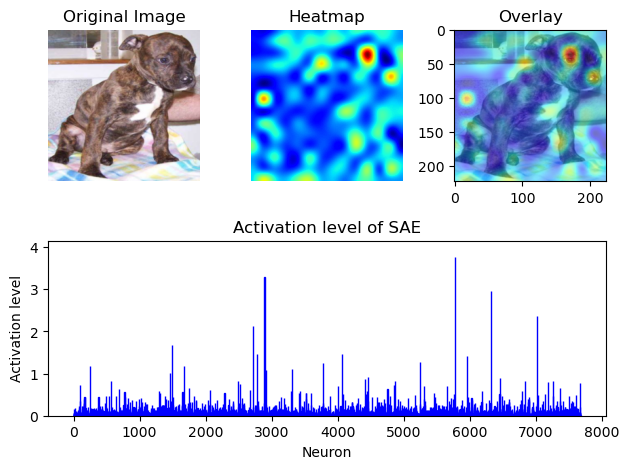

layer 4


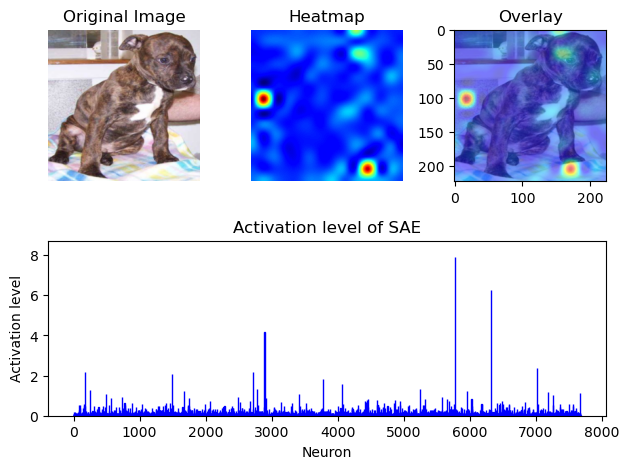

layer 5


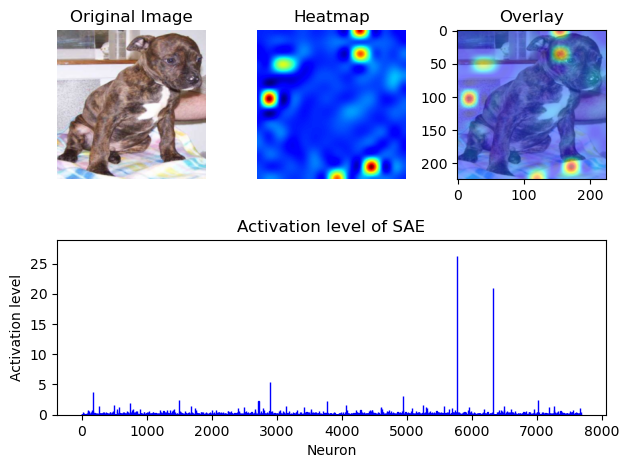

layer 6


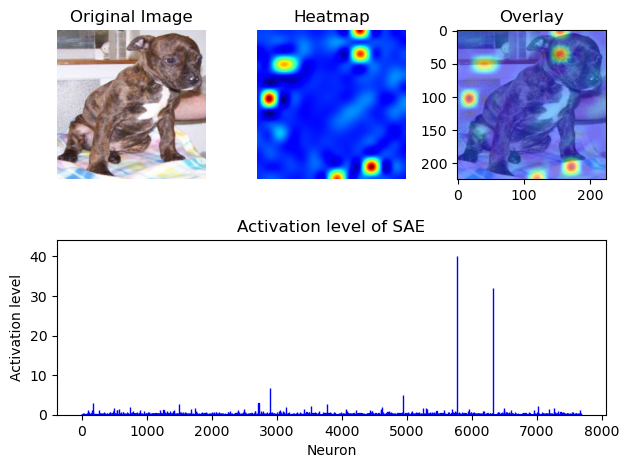

layer 7


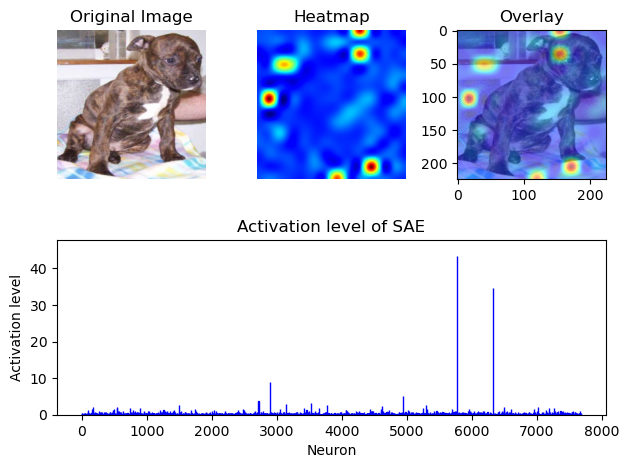

layer 8


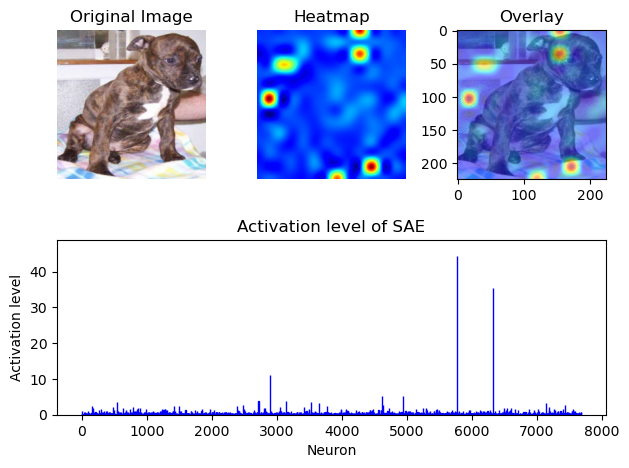

layer 9


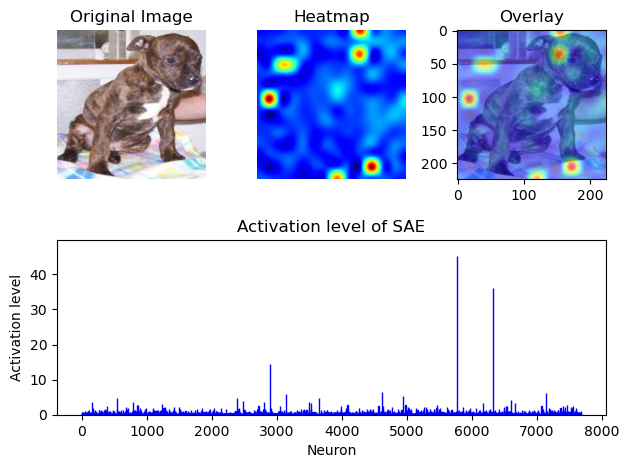

layer 10


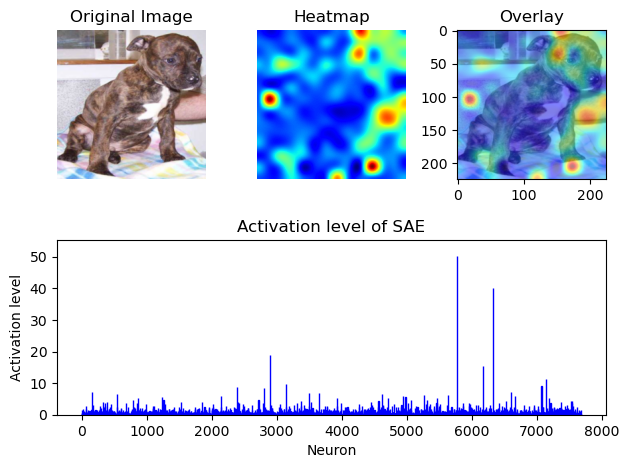

layer 11


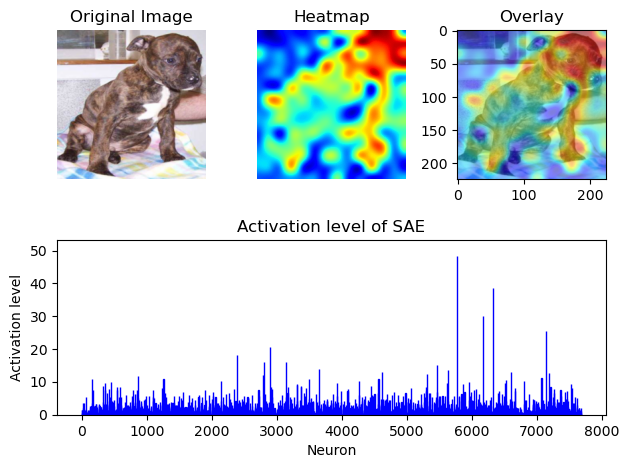

In [5]:
#run for all layers model ratio 10
for i in range(12):
    print(f'layer {i}')
    plot_activation('google/vit-base-patch16-224','SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth',input_image,layer_number = i, ratio=10, device= device)

for i in range(12):
    print(f'layer {i}')
    plot_activation('google/vit-base-patch16-224','SAE_models/catdog_finetune/SAE_ratio10_epoch100_lr0.0001.pth',input_image2,layer_number = i, ratio=10, device=device)


## Look into most activated features in All layers

In [6]:
activation_inputs1 = model(**input1)['hidden_states'][1:]
activation_inputs2 = model(**input2)['hidden_states'][1:]

# initiate the encoder and encoder_bias for SAE
encoder = torch.randn((7680, 768)) # encoder
nn.init.xavier_uniform_(encoder)
encoder_bias = torch.zeros(7680) # encoder bias

# Create a SAE instance
tied_sae = TiedSAE(encoder, encoder_bias)
tied_sae.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth'))
tied_sae.to_device(device)

tied_sae2 = TiedSAE(encoder, encoder_bias)
tied_sae2.load_state_dict(torch.load('SAE_models/catdog_finetune/SAE_ratio10_epoch100_lr0.0001.pth'))
tied_sae2.to_device(device)

# Calculate the activation levels for the input patch
activations_1 =[]
activations_2 =[]

for i in range(12):
    activations_1.append(tied_sae.encode(activation_inputs1[i]).squeeze(0))
    activations_2.append(tied_sae2.encode(activation_inputs2[i]).squeeze(0))


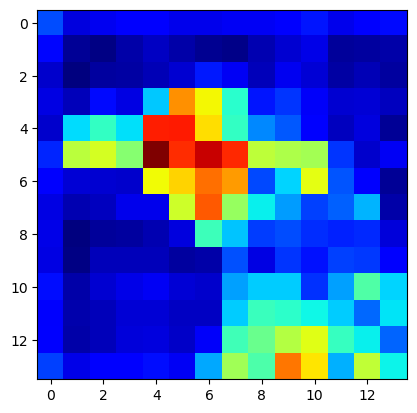

In [7]:
plt.imshow(activations_1[0][1:].mean(dim=1).cpu().detach().numpy().reshape(14,14), cmap='jet')

In [8]:
top_features1 = []
top_features2 = []

for i in range(12):
    # Detach the tensors before passing them to torch.topk()
    tensor1 = activations_1[i].mean(dim=0).detach().cpu()
    tensor2 = activations_2[i].mean(dim=0).detach().cpu()

    top_features1.append(torch.topk(tensor1, k=10, largest=True).indices)
    top_features2.append(torch.topk(tensor2, k=10, largest=True).indices)

In [9]:
print("Image 1")
[print(i) for i in top_features1]

print("Image 2")
[print(i) for i in top_features2]

Image 1
tensor([4753, 1145, 5735, 2924, 2328, 2636, 1997, 3612, 6037, 3487])
tensor([4753, 5735, 2924, 4279, 5653, 3033, 4865,  665, 5245,  185])
tensor([4753, 5735, 4279, 2924, 4865,    9, 5245, 5959,  665, 4561])
tensor([4753,    9, 5735, 5959, 4279, 6138, 4137, 4865, 2924, 6628])
tensor([4753, 4137,  880, 6535, 2684, 1298, 7454,  851, 6138,  977])
tensor([ 880, 6535, 2684, 1298, 7454,  851,  977, 2903,  589, 4753])
tensor([ 880, 6535, 2684, 1298, 7454,  851,  977, 2903,  589, 5479])
tensor([ 880, 6535, 2684, 1298, 7454,  851,  977, 2903,  589, 5479])
tensor([ 880, 6535, 2684, 1298, 7454,  851,  977, 2903,  589, 5479])
tensor([ 880, 6535, 2684, 1298, 7454,  851,  977, 2903,  589, 6628])
tensor([ 880, 6535, 2684, 6218, 1298, 7454,  851,  977, 2903, 6348])
tensor([ 880, 6535, 2684, 1298, 7454, 1613,  851,  977, 2903, 2792])
Image 2
tensor([5776, 2892, 6322, 2785, 5589, 3297, 3305, 1840,  568, 1853])
tensor([2892, 2785, 5776, 6322, 3297, 1289,  568, 5589, 2513, 3305])
tensor([2892, 2785

[None, None, None, None, None, None, None, None, None, None, None, None]

In [10]:
# extract top 10 features that activated in a input across all layers
def get_top_indices(top_features, num_top=10):
    tops = []
    for i in top_features:
        tops.append(i.cpu().detach().numpy())
    tops = np.concatenate(tops)

    # Count the occurrences of each value
    value_counts = Counter(tops)

    # Create a dictionary with value and counts
    value_counts_dict = dict(value_counts)
    sorted_counts = sorted(value_counts_dict.items(), key=lambda x: x[1], reverse=True)
    sorted_indices = [index for index, _ in sorted_counts[:num_top]]
    
    return sorted_indices

In [11]:
top_indices1 = get_top_indices(top_features1)
top_indices2 = get_top_indices(top_features2)

print(top_indices1)
print(top_indices2)

[880, 6535, 2684, 1298, 7454, 851, 977, 2903, 4753, 589]
[5776, 6322, 2892, 4937, 2785, 170, 4010, 6709, 1359, 5576]


## create heatmaps for most activated neurons in each layer

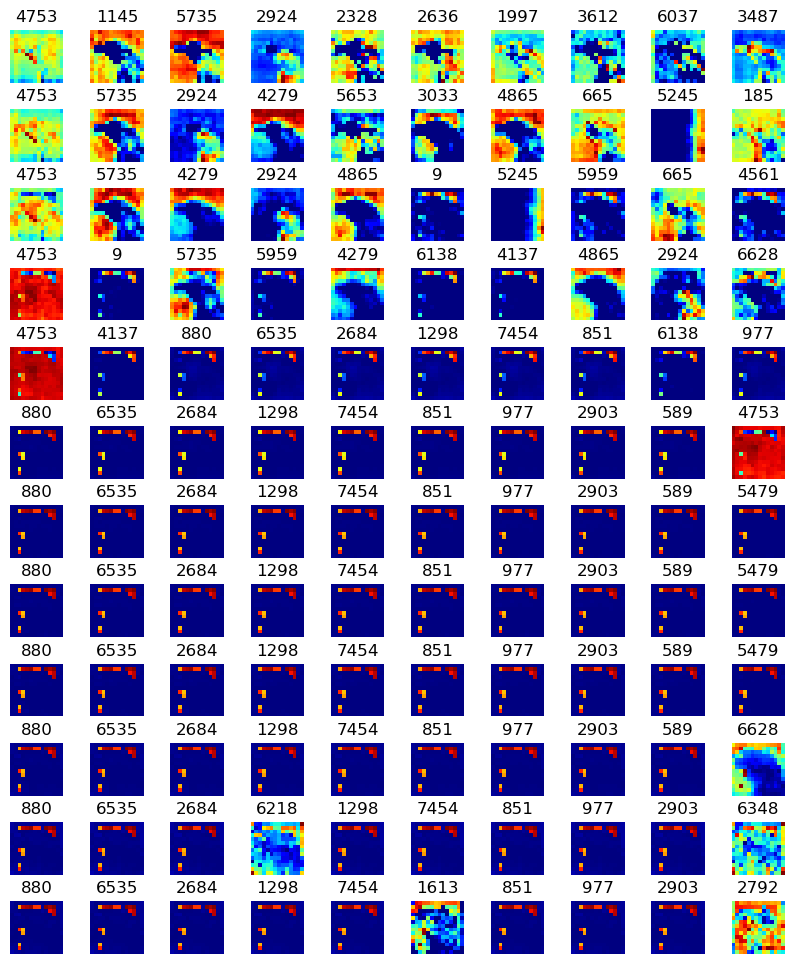

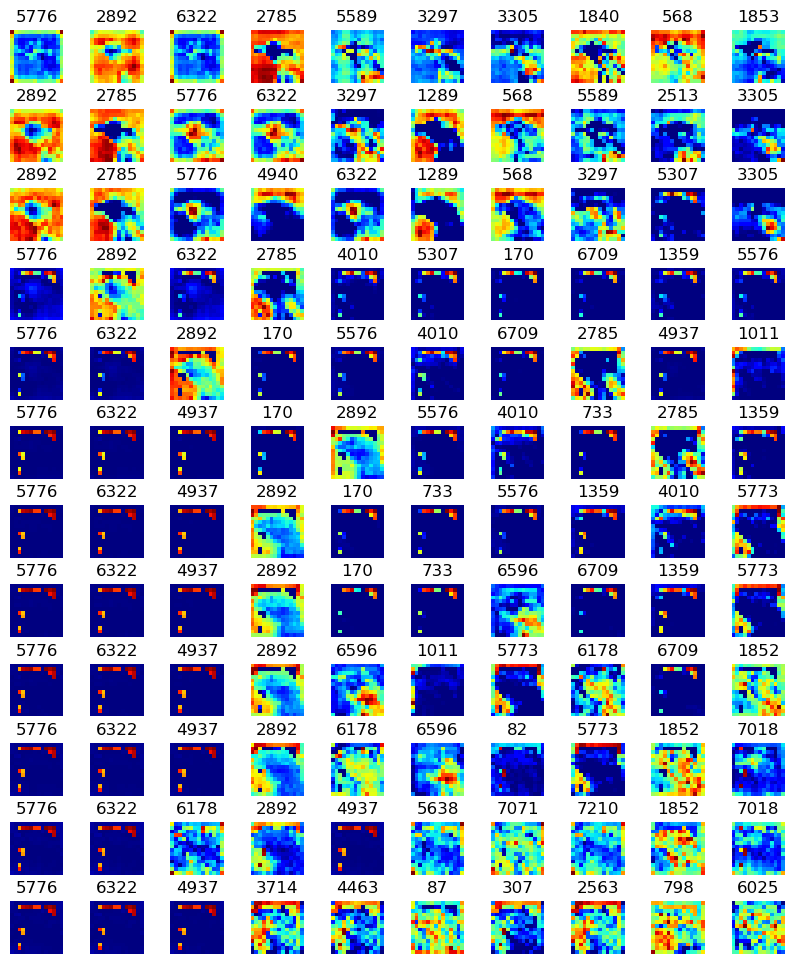

In [12]:
# Define a function to create a heatmap
def create_heatmap(activations, top_features):
    fig, axs = plt.subplots(12, 10, figsize=(10, 12))
    for i, layer_features in enumerate(top_features):
        for j, feature in enumerate(layer_features):
            ax = axs[i, j]
            sns.heatmap(activations[i][:,feature][1:].reshape(14,-1).detach().cpu().numpy(), cmap='jet', ax=ax, cbar=False)
            ax.set_title(f'{feature}')
            ax.axis('off')
    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust spacing between subplots
    plt.show()

# Call the function for each image
create_heatmap(activations_1, top_features1)
create_heatmap(activations_2, top_features2)